In [1]:
import os

sequence = '../data/ROUGH/marv/marv_2024-09-26-13-46-51/'
os.listdir(sequence)

['luxonis', 'clouds', 'controls', 'terrain', 'images', 'calibration', 'poses']

In [2]:
rgb_path = os.path.join(sequence, 'luxonis', 'rgb')
depth_path = os.path.join(sequence, 'luxonis', 'depth')

rgb_files = sorted(os.listdir(rgb_path))
depth_files = sorted(os.listdir(depth_path))
print(len(rgb_files), len(depth_files))

333 333


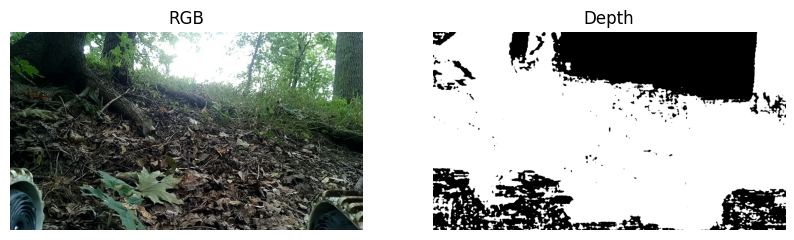

In [3]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

i = np.random.randint(len(rgb_files))
rgb = Image.open(os.path.join(rgb_path, rgb_files[i]))
depth = Image.open(os.path.join(depth_path, depth_files[i]))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title('RGB')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth, cmap='gray')
plt.title('Depth')
plt.axis('off')
plt.show()

# Depth Camera Intrinsic Parameters

To transform the depth image to a point cloud, we need the camera calibration parameters. The calibration files are stored in the `calibration` folder. The camera calibration is stored in the `*.yaml` files and the transformations between the cameras and the lidar are stored in `transformations.yaml`.


In [4]:
import yaml

calib_path = os.path.join(sequence, 'luxonis', 'calibration')
calib = {}
# read cameras-lidar transformations
trans_path = os.path.join(calib_path, 'transformations.yaml')
with open(trans_path, 'r') as f:
    transforms = yaml.load(f, Loader=yaml.FullLoader)
f.close()
calib['transformations'] = transforms
Tr_cam_robot = np.array(transforms['T_oak_rgb_camera_optical_frame__base_link']['data'], dtype=float).reshape(4, 4)
print(f'Camera to Robot Transformation:\n{Tr_cam_robot}')

# read camera calibration
file = 'luxonis_depth.yaml'
with open(os.path.join(calib_path, file), 'r') as f:
    cam_info = yaml.load(f, Loader=yaml.FullLoader)
    calib[file.replace('.yaml', '')] = cam_info
f.close()

K = np.array(cam_info['camera_matrix']['data'], dtype=float).reshape(3, 3)
print(f'Camera Matrix:\n{K}')

Camera to Robot Transformation:
[[ 0.    -1.     0.     0.   ]
 [-0.453  0.    -0.892  0.357]
 [ 0.892  0.    -0.453 -0.057]
 [ 0.     0.     0.     1.   ]]
Camera Matrix:
[[1.03168689e+03 0.00000000e+00 6.37444946e+02]
 [0.00000000e+00 1.03133374e+03 3.59812256e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


# Depth Image to Point Cloud

In [5]:
# Depth image to point cloud
def depth_to_pc(depth, K):
    H, W = depth.shape
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    x = np.arange(0, W) - cx
    y = np.arange(0, H) - cy
    xx, yy = np.meshgrid(x, y)
    Z = depth / 1000.0  # mm to meters
    X = xx * Z / fx
    Y = yy * Z / fy

    points = np.stack([X, Y, Z], axis=-1)
    points = points.reshape(-1, 3)
    return points

points = depth_to_pc(np.array(depth), K)

In [6]:
import open3d as o3d

mask = (points[:, 1] < 0.0)  # remove points below the ground
color = np.array(rgb).reshape(-1, 3) / 255.0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[mask])
pcd.colors = o3d.utility.Vector3dVector(color[mask])
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Compare to Lidar Point Cloud

In [7]:
clouds_path = os.path.join(sequence, 'clouds')
cloud_files = sorted(os.listdir(clouds_path))

cloud = np.load(os.path.join(clouds_path, cloud_files[i]))['cloud']
lidar_points = np.stack([cloud['x'], cloud['y'], cloud['z']], axis=-1)
print(lidar_points.shape)

(131072, 3)


In [8]:
# Visualize the lidar point cloud
pcd_lidar = o3d.geometry.PointCloud()
pcd_lidar.points = o3d.utility.Vector3dVector(lidar_points)
o3d.visualization.draw_geometries([pcd_lidar])

In [9]:
# Load the robot-lidar transformation
trans_path = os.path.join(sequence, 'calibration', 'transformations.yaml')
with open(trans_path, 'r') as f:
    transforms = yaml.load(f, Loader=yaml.FullLoader)
f.close()
# print(transforms.keys())
Tr_robot_lidar = np.array(transforms['T_base_link__os_sensor']['data'], dtype=float).reshape(4, 4)
print(f'Robot to Lidar Transformation:\n{Tr_robot_lidar}')

Robot to Lidar Transformation:
[[-0.707 -0.707  0.     0.065]
 [ 0.707 -0.707  0.     0.   ]
 [ 0.     0.     1.     0.408]
 [ 0.     0.     0.     1.   ]]


In [10]:
# Transform the lidar point cloud to the robot frame
lidar_points_robot = np.dot(Tr_robot_lidar[:3, :3], lidar_points.T).T + Tr_robot_lidar[:3, 3]

# Transform depth camera point cloud to robot frame
Tr_robot_cam = np.linalg.inv(Tr_cam_robot)
points_robot = np.dot(Tr_robot_cam[:3, :3], points.T).T + Tr_robot_cam[:3, 3]

In [11]:
# Visualize the point clouds
pcd_lidar = o3d.geometry.PointCloud()
pcd_lidar.points = o3d.utility.Vector3dVector(lidar_points_robot)
pcd_lidar.paint_uniform_color([0, 0, 1])

pcd_cam = o3d.geometry.PointCloud()
pcd_cam.points = o3d.utility.Vector3dVector(points_robot[mask])
pcd_cam.colors = o3d.utility.Vector3dVector(color[mask])

o3d.visualization.draw_geometries([pcd_lidar, pcd_cam])